# MERFISH Spatial Analysis of AON

The snRNA-seq data does not have any spatial info, so we can not tell from that alone which
cells are in the dorsolateral AON (where the contralateral projection neurons live). This
notebook uses MERFISH data from the Allen Brain Cell Atlas which has single-cell spatial coordinates across the whole mouse brain.

The goal is to see which AON glutamatergic clusters sit dorsolateral (target) vs
ventromedial (non-target), so we can label them for the DE analysis on the Allen 10x data.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path("../data").resolve()
ALLEN_DIR = DATA_DIR / "allen_brain_atlas"
OUTPUT_DIR = Path("../output").resolve()

## Load MERFISH Metadata

The Allen Brain Cell Atlas MERFISH dataset contains ~3.9 million cells with CCF spatial
coordinates and pre-assigned cluster labels. Only loading the columns needed for spatial
analysis to keep memory manageable.

In [2]:
usecols = ['cell_label', 'x', 'y', 'z', 'cluster', 'supertype', 'subclass']

merfish = pd.read_csv(
    ALLEN_DIR / "merfish_cell_metadata_with_group_membership.csv",
    usecols=usecols
)
print(f"Total MERFISH cells: {len(merfish):,}")

Total MERFISH cells: 3,938,808


## Filter to AON Glutamatergic Neurons

The Allen taxonomy defines five glutamatergic supertypes within the AON region under the
label "IT AON-TT-DP Glut" (intratelencephalic, AON / taenia tecta / dorsal peduncular area).
These are the populations most relevant to our question about contralateral projections,
since the projection neurons of interest are glutamatergic.

In [3]:
aon = merfish[merfish['supertype'].str.contains('IT AON-TT-DP Glut', na=False)].copy()
print(f"AON glutamatergic cells: {len(aon):,}")

print("\nCluster distribution:")
print(aon['supertype'].value_counts().sort_index())

AON glutamatergic cells: 27,076

Cluster distribution:
supertype
0046 IT AON-TT-DP Glut_1     5905
0047 IT AON-TT-DP Glut_2     3808
0048 IT AON-TT-DP Glut_3     3706
0049 IT AON-TT-DP Glut_4     2236
0050 IT AON-TT-DP Glut_5    11421
Name: count, dtype: int64


## Spatial Distribution by Cluster

Plotting each Glut cluster in CCF coordinates to see where they sit within the AON.
If the dorsolateral vs ventromedial distinction holds, we should see spatial segregation
between cluster groups.

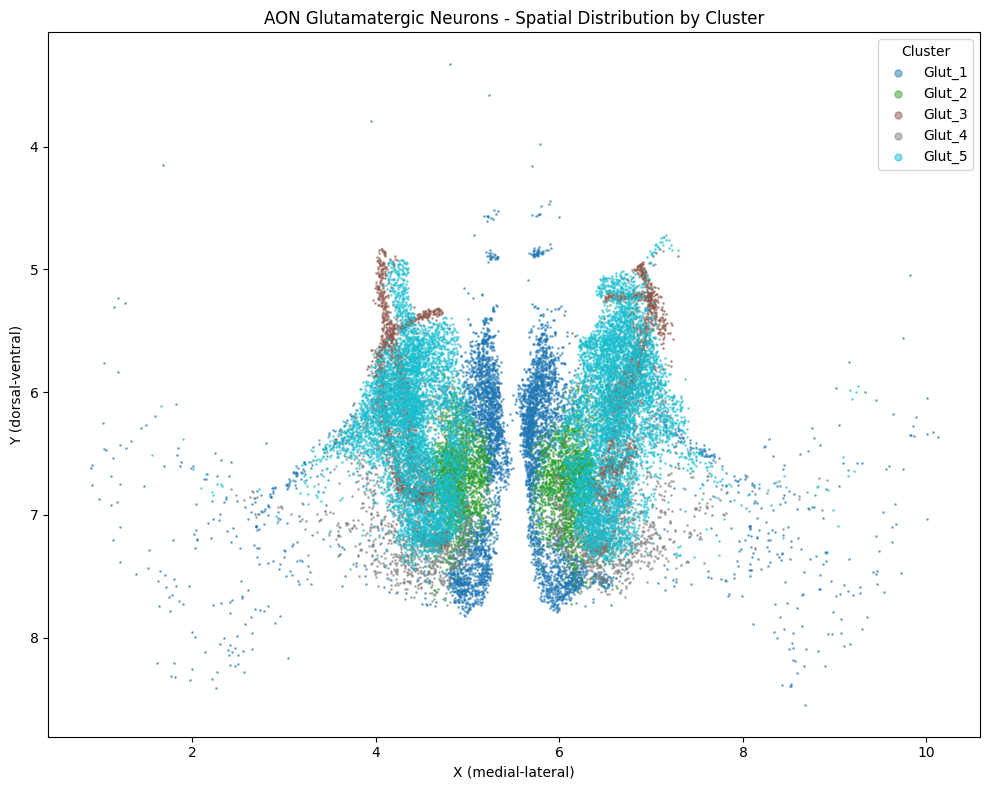

In [4]:
aon['glut_cluster'] = aon['supertype'].str.extract(r'(Glut_\d+)$')

cluster_order = sorted(aon['glut_cluster'].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(cluster_order)))
color_map = dict(zip(cluster_order, colors))

fig, ax = plt.subplots(figsize=(10, 8))

for cluster in cluster_order:
    subset = aon[aon['glut_cluster'] == cluster]
    ax.scatter(
        subset['x'], subset['y'],
        c=[color_map[cluster]],
        label=cluster,
        s=1, alpha=0.5
    )

ax.set_xlabel('X (medial-lateral)')
ax.set_ylabel('Y (dorsal-ventral)')
ax.set_title('AON Glutamatergic Neurons - Spatial Distribution by Cluster')
ax.legend(title='Cluster', markerscale=5)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Target vs Non-target Classification

From the spatial plot above, Glut_3, Glut_4, and Glut_5 are in the dorsolateral region,
calling those **Target**. Glut_1 and Glut_2 sit ventromedially, **Non-target**.

These labels get carried over to the Allen 10x DE analysis to find genes enriched in
the target population.

In [5]:
target_clusters = ['Glut_3', 'Glut_4', 'Glut_5']
nontarget_clusters = ['Glut_1', 'Glut_2']

def classify_group(glut_cluster):
    if glut_cluster in target_clusters:
        return 'Target (dorsolateral)'
    elif glut_cluster in nontarget_clusters:
        return 'Non-target (ventromedial)'
    return 'Other'

aon['group'] = aon['glut_cluster'].apply(classify_group)

print("Group sizes:")
print(aon['group'].value_counts())

Group sizes:
group
Target (dorsolateral)        17363
Non-target (ventromedial)     9713
Name: count, dtype: int64


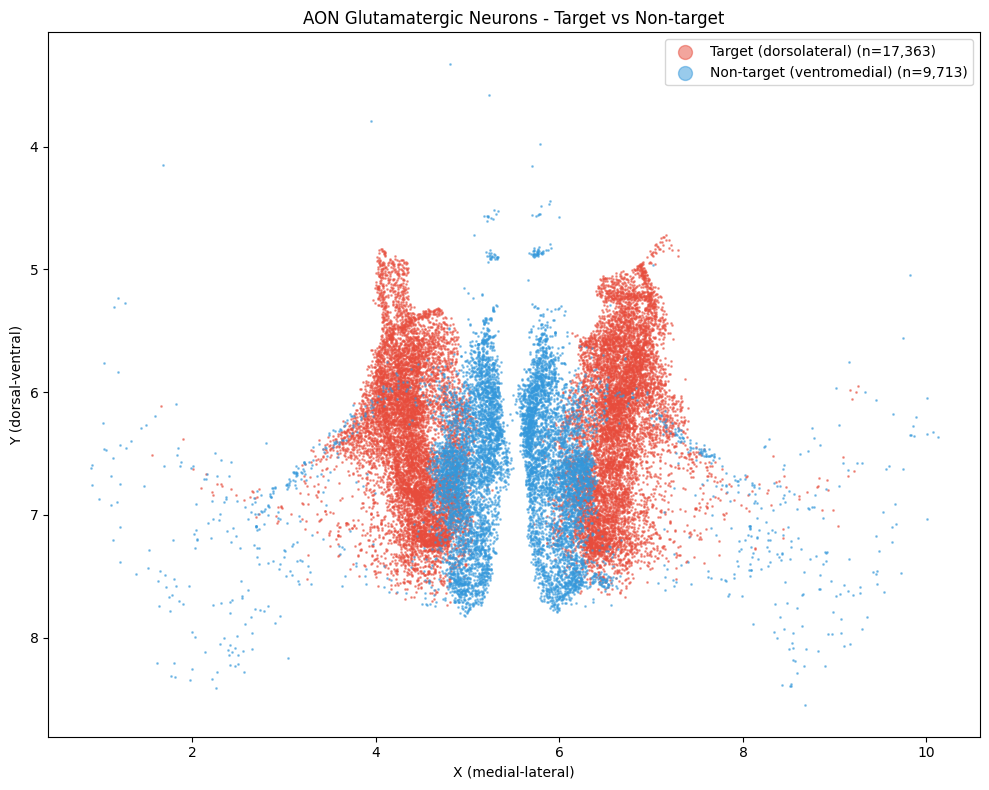

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

group_colors = {
    'Target (dorsolateral)': '#e74c3c',
    'Non-target (ventromedial)': '#3498db'
}

for group, color in group_colors.items():
    subset = aon[aon['group'] == group]
    ax.scatter(
        subset['x'], subset['y'],
        c=color,
        label=f"{group} (n={len(subset):,})",
        s=1, alpha=0.5
    )

ax.set_xlabel('X (medial-lateral)')
ax.set_ylabel('Y (dorsal-ventral)')
ax.set_title('AON Glutamatergic Neurons - Target vs Non-target')
ax.legend(markerscale=10)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Spatial Statistics

Quantifying the spatial separation between Target and Non-target groups across all three
CCF axes to confirm the visual impression from the scatter plots.

In [7]:
spatial_stats = aon.groupby('group', observed=True)[['x', 'y', 'z']].agg(['mean', 'std']).round(1)
print("Spatial statistics by group:")
print(spatial_stats)

target = aon[aon['group'] == 'Target (dorsolateral)']
nontarget = aon[aon['group'] == 'Non-target (ventromedial)']

print(f"\nMean Y (dorsal-ventral) difference:")
print(f"  Target: {target['y'].mean():.1f}")
print(f"  Non-target: {nontarget['y'].mean():.1f}")
print(f"  Delta: {target['y'].mean() - nontarget['y'].mean():.1f} (negative = more dorsal)")

Spatial statistics by group:
                             x         y          z     
                          mean  std mean  std  mean  std
group                                                   
Non-target (ventromedial)  5.5  0.9  6.6  0.6  10.7  0.7
Target (dorsolateral)      5.5  1.2  6.3  0.6  11.8  0.6

Mean Y (dorsal-ventral) difference:
  Target: 6.3
  Non-target: 6.6
  Delta: -0.3 (negative = more dorsal)


## Summary

Target and Non-target groups clearly separate spatially. The Z-axis (anteroposterior, delta = 1.1) shows stronger separation than Y (dorsoventral, delta = 0.3), so these populations differ more in their front-to-back position than dorsal-ventral.

Worth noting: the Allen 10x dataset uses finer cluster IDs than these MERFISH supertypes.
Some sub-clusters within a supertype (like 0175, a Glut_3 sub-cluster) don't follow the
spatial pattern of their parent group and get assigned to Non-target individually.